https://arxiv.org/pdf/1312.6114.pdf (vae paper)<br/>
https://docs.google.com/presentation/d/1FkkhH86URDzAzjNPdCvupV6kqoBNNarVQQgB6ppZlx4/edit#slide=id.g26890724310_0_7 (latent variable models lecture notes) <br/>

In [ ]:
# !pip install datasets
# !pip install wandb
# !pip install librosa

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torch.utils.data import default_collate, DataLoader
from datasets import load_dataset
import matplotlib.pyplot as plt
import wandb
import numpy as np
import librosa
import os
import IPython as ipy
import librosa
import random
from scipy.ndimage import zoom

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('device', device)

device cpu


In [ ]:
!wandb login

wandb: Currently logged in as: carlfeynman. Use `wandb login --relogin` to force relogin


In [ ]:
def find_wav_files(directory):
    wav_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(".wav"):
                wav_files.append(os.path.join(root, file))
    return wav_files

directory = '../datasets/cat_dog_sound/'
audio_files = list(set(find_wav_files(directory)))
len(audio_files)
audio_files[0]

'../datasets/cat_dog_sound/cats_dogs/train/cat/cat_159.wav'

In [ ]:
# dataset_path = '../datasets/cat_dog_sound/cats_dogs/train/cat/'
# audio_files = [dataset_path+o for o in list(os.listdir(dataset_path))]
print('total audio files:', len(audio_files))

total audio files: 554


In [ ]:
file1 = audio_files[0]
ipy.display.display(ipy.display.Audio(file1))

In [ ]:
data,sample_rate = librosa.load(file1, sr=None) 
print(sample_rate)
print(data.shape)
print(data.min(), data.max())

16000
(192000,)
-0.99902344 0.6614685


In [ ]:
data_normalized = librosa.util.normalize(data)
print(data_normalized.shape)
print(data_normalized.min(), data_normalized.max())

(192000,)
-1.0 0.6621151


In [ ]:
mel_spectrogram = librosa.feature.melspectrogram(y=data_normalized, sr=sample_rate, n_mels=128)
mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

In [ ]:
print(mel_spectrogram_db.shape)
print(mel_spectrogram_db.min(), mel_spectrogram_db.max())

(128, 376)
-80.0 0.0


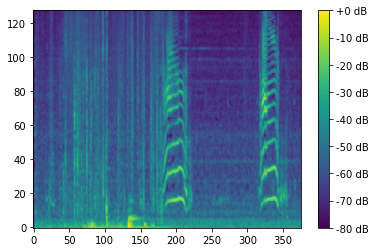

In [ ]:
plt.imshow(mel_spectrogram_db, aspect='auto', origin='lower', cmap='viridis');
plt.colorbar(format='%+2.0f dB');

In [ ]:
mel_spectrogram = librosa.db_to_power(mel_spectrogram_db)

In [ ]:
stft_magnitude = librosa.feature.inverse.mel_to_stft(mel_spectrogram, sr=sample_rate, n_fft=2048)

In [ ]:
reconstructed_audio = librosa.griffinlim(stft_magnitude, hop_length=512, n_iter=32)

In [ ]:
ipy.display.display(ipy.display.Audio(reconstructed_audio, rate=sample_rate))

In [ ]:
def wav_to_mel(wav_file):
    data, sample_rate = librosa.load(wav_file, sr=None) 
    data_normalized = librosa.util.normalize(data)
    
    mel_spectrogram = librosa.feature.melspectrogram(y=data_normalized, sr=sample_rate, n_mels=128)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

    return mel_spectrogram_db, sample_rate

def mel_to_wav(mel_db, sample_rate):
    mel_spectrogram = librosa.db_to_power(mel_db)
    stft_magnitude = librosa.feature.inverse.mel_to_stft(mel_spectrogram, sr=sample_rate, n_fft=2048)
    reconstructed_audio = librosa.griffinlim(stft_magnitude, hop_length=512, n_iter=32)
    return reconstructed_audio

In [ ]:
audio_file = random.choice(audio_files)
ipy.display.display(ipy.display.Audio(audio_file))

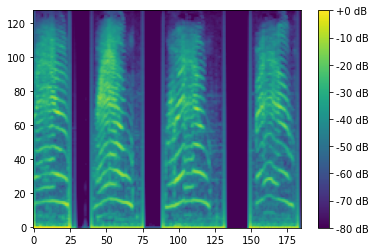

In [ ]:
mel_db, sr = wav_to_mel(audio_file)
plt.imshow(mel_db, aspect='auto', origin='lower', cmap='viridis');
plt.colorbar(format='%+2.0f dB');

In [ ]:
reconstructed_audio = mel_to_wav(mel_db, sr)
ipy.display.display(ipy.display.Audio(reconstructed_audio, rate=sr))

In [ ]:
audio_data = []
for file in audio_files:
    mel_db, sr = wav_to_mel(audio_file)
    audio_data.append({
        'sr': sr,
        'mel_db': torch.tensor(mel_db.tolist())
    })
print(len(audio_data))

554


In [ ]:
def collate_dict(b):
    c = default_collate(b)
    return (c['mel_db'].to(device), c['sr'])

In [ ]:
batch_size = 20
train_dl = DataLoader(audio_data, batch_size=batch_size, shuffle=True, collate_fn=collate_dict)
print(len(train_dl))

28


In [ ]:
xb,yb = next(iter(train_dl))
xb[:,None].shape

torch.Size([20, 1, 128, 185])

In [ ]:
xb,yb = next(iter(train_dl))
xb.shape,yb.shape

(torch.Size([20, 128, 185]), torch.Size([20]))

In [ ]:
xb[10][:,None].shape

torch.Size([128, 1, 185])

tensor(16000)


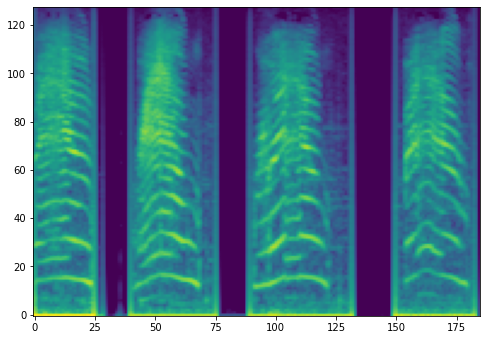

In [ ]:
plt.figure(figsize=(8, 8),)
plt.imshow(xb[:,None][10][0].detach().cpu(), origin='lower');
print(yb[10])

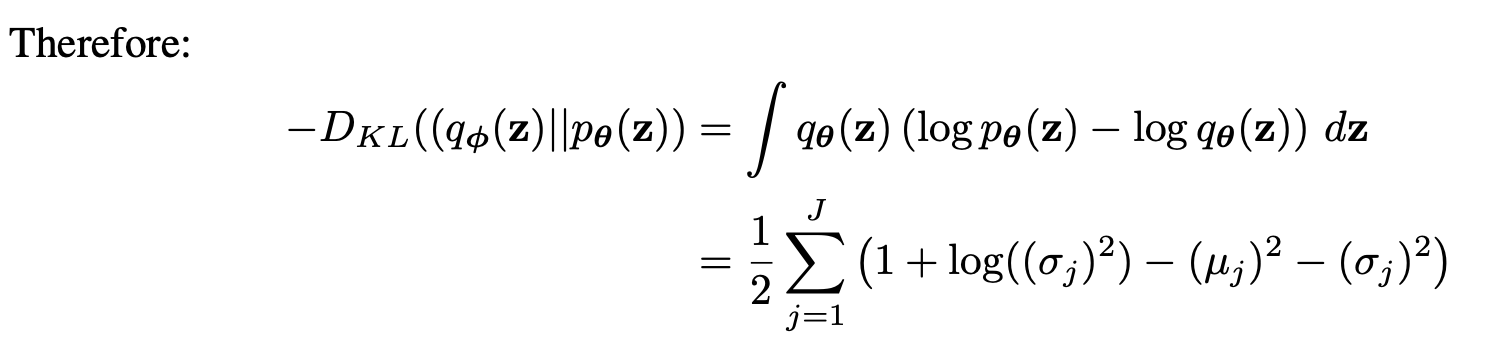

In [ ]:
class VariationalAutoEncoder(nn.Module):
    def __init__(self, latent_dim=50, beta=1):
        super().__init__()
        self.latent_dim = latent_dim
        self.beta = beta

        self.stride = 2
        self.kernel_size = 3
        self.padding = self.kernel_size//2

        self.enc = nn.Sequential(*[
            nn.Conv2d(1, 8, kernel_size=self.kernel_size, padding=self.padding, stride=self.stride),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=self.kernel_size, padding=self.padding, stride=self.stride),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=self.kernel_size, padding=self.padding, stride=self.stride),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=self.kernel_size, padding=self.padding, stride=self.stride),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=self.kernel_size, padding=self.padding, stride=self.stride),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3072, self.latent_dim)
        ])

        self.mu_layer = nn.Linear(self.latent_dim, self.latent_dim)
        self.log_var_layer = nn.Linear(self.latent_dim, self.latent_dim)

        self.dec = nn.Sequential(*[
            nn.Linear(self.latent_dim, 64*2*2),
            nn.ReLU(),
            nn.Unflatten(1, (64,2,2)),
            nn.ConvTranspose2d(64, 32, kernel_size=self.kernel_size,
                               padding=self.padding, stride=self.stride, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=self.kernel_size,
                               padding=self.padding, stride=self.stride, output_padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, kernel_size=self.kernel_size,
                               padding=self.padding, stride=self.stride, output_padding=1),
            nn.BatchNorm2d(8),

            nn.ReLU(),
            nn.ConvTranspose2d(8, 1, kernel_size=self.kernel_size,
                               padding=self.padding, stride=2, output_padding=0),
            nn.BatchNorm2d(1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(961, 128*376),
            nn.Unflatten(1, (1, 128, 376)),
            nn.Sigmoid()
        ])

    def reparameterize(self, mu, log_var):
      std = torch.exp(0.5*log_var)
      eps = torch.randn_like(std)
      return mu + eps*std

    def loss(self, xb, out, mu, log_var):
      self.rec_loss = F.mse_loss(xb, out, reduction='mean')
      self.kl_loss = -0.5*torch.sum(1 + log_var - mu.pow(2) - log_var.exp(), dim=1).mean(dim=0)
      return self.rec_loss + self.beta*self.kl_loss

    def forward(self, x):
        latent = self.enc(x)
       
    
        mu = self.mu_layer(latent)
        log_var = self.log_var_layer(latent)

        z = self.reparameterize(mu, log_var)
        out = self.dec(z)

        return out, mu, log_var

In [ ]:
model = VariationalAutoEncoder().to(device)
# model

In [ ]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = f"{total_params / 1_000_000:.2f}M"
print(f"total number of parameters: {total_params}")

total number of parameters: 46.56M


In [ ]:
xb[:,None].shape

torch.Size([20, 1, 128, 376])

In [ ]:
out,mu,log_var = model(xb[:,None])
out.shape,mu.shape,log_var.shape

(torch.Size([20, 1, 128, 376]), torch.Size([20, 50]), torch.Size([20, 50]))

In [ ]:
epochs = 1
lr = 6e-3
model = VariationalAutoEncoder().to(device)
opt = torch.optim.AdamW(model.parameters(), lr=lr)

wandb.init(
    project="variational_autoencoder_audio",
    config={
      "batch_size": batch_size,
      "learning_rate": lr,
      "architecture": "CNN",
      "dataset": "MNIST",
      "epochs": epochs,
      "total_params": total_params,
      "model":model
    }
)

for epoch in range(epochs):
    for xb,yb in train_dl:
        xb = xb[:,None]
        out,mu,log_var = model(xb)
        loss = model.loss(xb, out, mu, log_var)
        loss.backward()
        opt.step()
        opt.zero_grad()

        with torch.no_grad():
          sample_mu = torch.zeros((5, model.latent_dim))
          sample_log_var = torch.ones((5, model.latent_dim))
          samples = model.reparameterize(sample_mu, sample_log_var)
          samples_out = model.dec(samples)

          wandb.log({"loss": round(loss.item(), 4),
                     "reconstruct_loss": round(model.rec_loss.item(), 4),
                     "kl_loss": round(model.kl_loss.item(), 4)})
          orginial_img = [wandb.Image(o, caption="original") for o in xb.detach().cpu()[:5]]
          reconstructed_img = [wandb.Image(o, caption="reconstructed_img") for o in out.detach().cpu()[:5]]
          generated_sample = [wandb.Image(o, caption="generated_sample") for o in samples_out.detach().cpu()[:5]]
          wandb.log({"original": orginial_img, "reconstructed_img": reconstructed_img, 'generated_sample':generated_sample})

    print(f"loss {loss.item():.4f}")

wandb.finish()

loss 3050.1487


kl_loss,▁█▁▁▁▁▁
loss,▁█▁▁▁▁▁
reconstruct_loss,█▄▁▁▁▁▁
kl_loss,64.3171
loss,3050.1487
reconstruct_loss,2985.8315


In [ ]:
# wandb.finish()

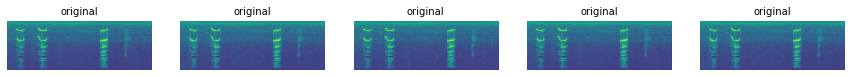

In [ ]:
plot_sz = 5
_,axs = plt.subplots(1, plot_sz, figsize=(15, 15))
for im,ax in zip(xb,axs.flat):
  ax.imshow(im.permute(1,2,0).detach().cpu());
  ax.axis('off')
  ax.set_title('original', fontsize=10)

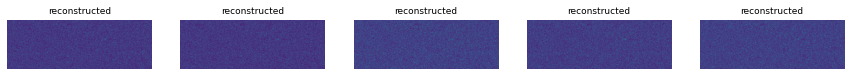

In [ ]:
_,axs = plt.subplots(1, plot_sz, figsize=(15, 15))
for im,ax in zip(out,axs.flat):
  ax.imshow(im.permute(1,2,0).detach().cpu());
  ax.axis('off')
  ax.set_title('reconstructed', fontsize=9)

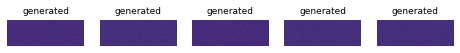

In [ ]:
_,axs = plt.subplots(1, 5, figsize=(8, 8))
for im,ax in zip(samples_out,axs.flat):
  ax.imshow(im.permute(1,2,0).detach().cpu());
  ax.axis('off')
  ax.set_title('generated', fontsize=9)